In [59]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
#from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_us = pd.read_csv('us.csv')

In [4]:
df_us.set_index('date', inplace = True)

In [5]:
df_us.shape

(239, 2)

In [6]:
df_us.head()

,cases,deaths
date,,
2020-01-21,1,0
2020-01-22,1,0
2020-01-23,1,0
2020-01-24,2,0
2020-01-25,3,0


<AxesSubplot:xlabel='date'>

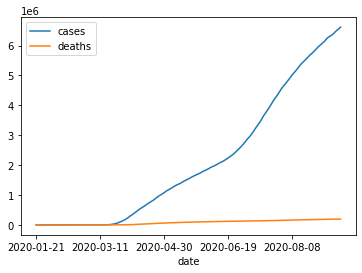

In [7]:
df_us.plot()

In [10]:
df_us['case_day'] = df_us['cases'].diff()
df_us['case_day'][0] = 1
df_us['case_day'] =  df_us['case_day'].astype('int')

In [11]:
df_us['case_day']

date
2020-01-21        1
2020-01-22        0
2020-01-23        0
2020-01-24        1
2020-01-25        1
              ...  
2020-09-11    47548
2020-09-12    39149
2020-09-13    33369
2020-09-14    36836
2020-09-15    39224
Name: case_day, Length: 239, dtype: int64

In [13]:
df_us['case_day'].describe()

count      239.000000
mean     27674.108787
std      21008.903281
min          0.000000
25%       6067.500000
50%      26237.000000
75%      43120.000000
max      75682.000000
Name: case_day, dtype: float64

<AxesSubplot:xlabel='date'>

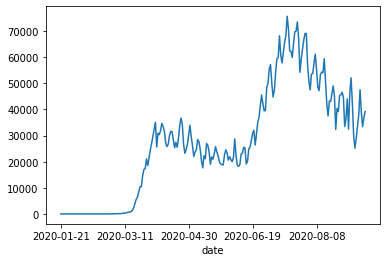

In [14]:
df_us['case_day'].plot()


In [15]:
test = adfuller(df_us['case_day'])
test_cases_day = pd.Series(test[0:4], index = ['Test Statstic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print(test_cases_day)
# P-value > 0.05 Not Stationary


Test Statstic                   -1.907827
p-value                          0.328388
#Lags Used                      15.000000
Number of Observations Used    223.000000
dtype: float64


## Differencing 


In [12]:
diff1 = df_us['case_day'] - df_us['case_day'].shift(1)

In [13]:
diff1 = diff1.dropna()

In [14]:
test = adfuller(diff1)
test_diff1 = pd.Series(test[0:4], index = ['Test Statstic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print(test_diff1)
# pvalue still > 0.05 

Test Statstic                   -2.260045
p-value                          0.185178
#Lags Used                      14.000000
Number of Observations Used    223.000000
dtype: float64


In [15]:
diff2 = diff1 - diff1.shift(1)
diff2 = diff2.dropna()

In [16]:
test = adfuller(diff2)
test_diff2 = pd.Series(test[0:4], index = ['Test Statstic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print(test_diff2)
# pvalue still > 0.05 

Test Statstic                 -6.783965e+00
p-value                        2.458934e-09
#Lags Used                     1.300000e+01
Number of Observations Used    2.230000e+02
dtype: float64


### p-value < 0.05 
Series stationary at d = 2

## Plotting ACF and PACF

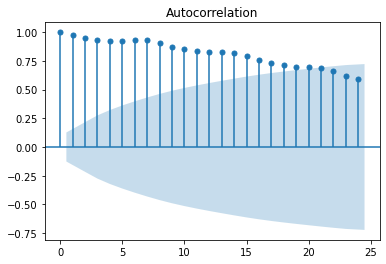

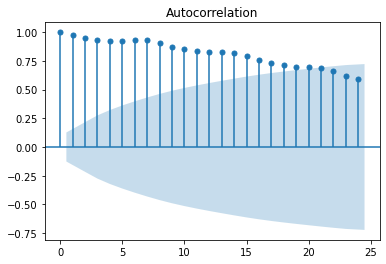

In [17]:
plot_acf(df_us['case_day'], alpha = 0.05) # q = 1-20

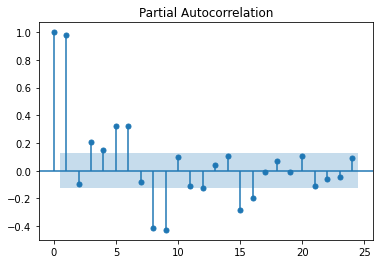

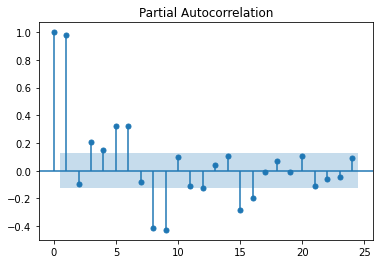

In [18]:
plot_pacf(df_us['case_day'], alpha = 0.05) # p = 3

## Train Test Split

In [16]:
train = df_us['case_day'].loc['2020-01-21':'2020-09-05']
test = df_us['case_day'].loc['2020-09-06':]

## ARIMA model

In [20]:
arima = ARIMA(train, order=(2, 2, 2))
arima_fit = arima.fit(disp= 0)
print(arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.case_day   No. Observations:                  227
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -2183.376
Method:                       css-mle   S.D. of innovations           3609.183
Date:                Thu, 17 Sep 2020   AIC                           4378.752
Time:                        16:33:54   BIC                           4399.301
Sample:                    01-23-2020   HQIC                          4387.044
                         - 09-05-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.2530     22.727      0.055      0.956     -43.290      45.796
ar.L1.D2.case_day     0.7132      0.070     10.235      0.000       0.577       0.850
ar.L2.D2.case_day    -0.

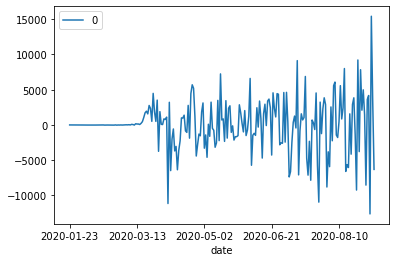

In [21]:
residuals = pd.DataFrame(arima_fit.resid)
residuals.plot()
pyplot.show()

In [22]:
preds = arima_fit.forecast(steps = 10)[0]

In [23]:
preds

array([38363.66840285, 39532.85877425, 42060.04876133, 43604.97966522,
       43928.85161885, 43759.80579642, 43708.83054373, 43932.14062232,
       44306.58267637, 44684.35103226])

In [24]:
np.sqrt(mean_squared_error(preds, test))

9070.773231902464

In [25]:
df_us['case_day'].describe()

count      239.000000
mean     27674.108787
std      21008.903281
min          0.000000
25%       6067.500000
50%      26237.000000
75%      43120.000000
max      75682.000000
Name: case_day, dtype: float64

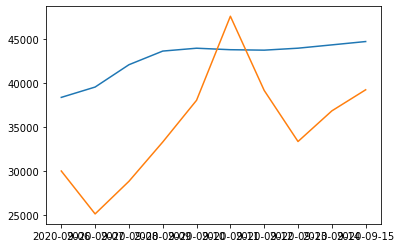

In [26]:
pyplot.plot(preds)
pyplot.plot(test)

### Grid Search for ARIMA

In [27]:
def evaluate_arima_model(training, testing ,arima_order):
    model = ARIMA(training, order = arima_order)
    model_fit = model.fit(disp=0)
    preds = model_fit.forecast(steps = 10)[0]
    error = np.sqrt(mean_squared_error(testing, preds))
    return error

In [28]:
def evaluate_models(training, testing, p_values, d_values, q_values):
    rmse_list = []
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(training, testing, order)
                    rmse_list.append([rmse,order])
                except:
                    continue
    return rmse_list

In [29]:
p_values = range(1,10)
d_values = range(1,3)
q_values = range(1,20)

In [30]:
rmse_order = evaluate_models(train, test, p_values, d_values, q_values)

In [31]:
rmse_order = sorted(rmse_order, key=lambda x: x[0])

In [32]:
rmse_order[0]

[6609.899495639759, (7, 1, 6)]

## ARIMA with best parameters

In [33]:
best_arima = ARIMA(train, order=(7, 1, 6))
best_arima_fit = best_arima.fit(disp= 0)


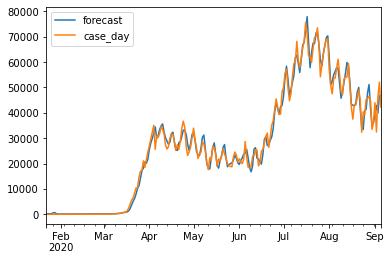

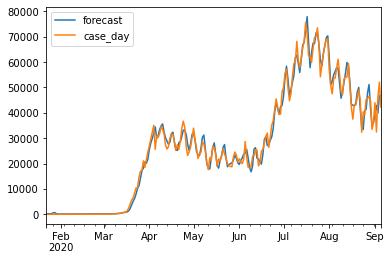

In [34]:
best_arima_fit.plot_predict()

In [36]:
preds = best_arima_fit.forecast(steps = 10)[0]

In [37]:
best_rmse = np.sqrt(mean_squared_error(preds, test))
print('Best ARIMA RMSE: ',best_rmse)

Best ARIMA RMSE:  6609.899495639759


In [38]:
preds

array([36615.30462049, 36765.99442138, 39297.71359229, 39733.49376976,
       45984.27933713, 50194.65470207, 44271.73178117, 36772.61124462,
       37835.74510717, 39453.06556671])

In [39]:
test

date
2020-09-06    30030
2020-09-07    25173
2020-09-08    28864
2020-09-09    33313
2020-09-10    38036
2020-09-11    47548
2020-09-12    39149
2020-09-13    33369
2020-09-14    36836
2020-09-15    39224
Name: case_day, dtype: int32

## Simple Exponential Smoothing(SES)

In [40]:
ses = SimpleExpSmoothing(train)
ses_fit = ses.fit()

In [41]:
ses_preds = ses_fit.forecast(steps = 10)

In [42]:
ses_preds

2020-09-06    42326.969447
2020-09-07    42326.969447
2020-09-08    42326.969447
2020-09-09    42326.969447
2020-09-10    42326.969447
2020-09-11    42326.969447
2020-09-12    42326.969447
2020-09-13    42326.969447
2020-09-14    42326.969447
2020-09-15    42326.969447
Freq: D, dtype: float64

In [43]:
np.sqrt(mean_squared_error(ses_preds, test))

9400.91892825152

## FBPROPHET

In [26]:
X = pd.DataFrame(train)

In [27]:
X.rename(columns = {'case_day':'y'}, inplace = True)
X.index.names = ['ds']
X.head()

,y
ds,
2020-01-21,1
2020-01-22,0
2020-01-23,0
2020-01-24,1
2020-01-25,1


In [28]:
X['index'] = np.arange(len(X))

,y
index,
0,1
1,0
2,0
3,1
4,1
...,...
224,44027
225,32464
226,46348


In [33]:
X['ds'] = X.index

In [35]:
X.set_index('index', inplace = True)


In [36]:
model = Prophet()
model.fit(X)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [37]:
future = model.make_future_dataframe(periods = 10)
future.tail()

,ds
234,2020-09-11
235,2020-09-12
236,2020-09-13
237,2020-09-14
238,2020-09-15


In [38]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
234,2020-09-11,61140.671602,48290.906044,74698.443755
235,2020-09-12,58248.884248,45800.875604,71922.554945
236,2020-09-13,54645.557334,42209.042424,66925.427378
237,2020-09-14,55171.404154,42604.032916,67810.588250
238,2020-09-15,57505.105024,44637.397269,70162.943388


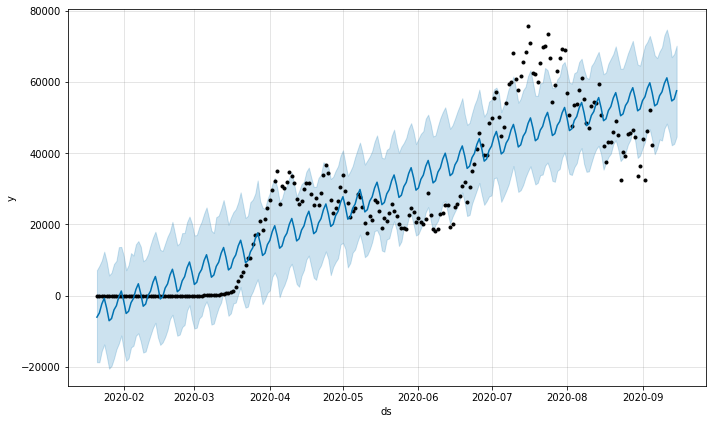

In [40]:
fig1 = model.plot(forecast)


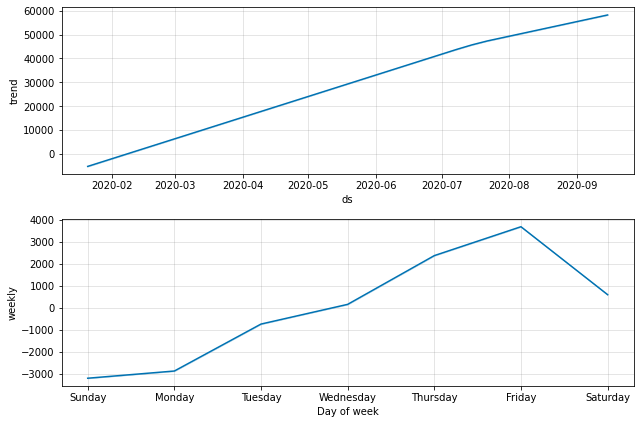

In [42]:
fig2 = model.plot_components(forecast)

In [60]:
plot_plotly(model, forecast)



NameError: name 'go' is not defined

In [58]:
plot_components_plotly(model, forecast)



NameError: name 'go' is not defined

In [65]:
np.sqrt(mean_squared_error(test, forecast['yhat'].tail(10)))


21934.665070102892